<center><h1> Multi Subject Dictionnary Learning to segment Atlas of Brain <h1><center>

<h2><u>1- Generation of synthetic data</u><h2>

In [31]:
from utils import *
from blob import *
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from typing import List
import copy


<h3><u>a- Group level latent spatial map</u><h3>

<span style="font-size: 15px;"> 
We first create group levels latent maps using a blob model: <br>  

- Each map is made of "a few cones-shaped localized patterns the position and size of which are chosen randomly". <br>    
- The number of blobs on each map follows a binomial distribution of parameters (3,0.5).  <br>
- We generate maps one after the other and we avoid overlapping between blob centers across the maps.  <br>
</span>


In [32]:
def create_latent_maps(grid_length: int = 50, k:int = 5):
    """_summary_

    Args:
        grid_length (int, optional): _description_. Defaults to 50.
        k (int, optional): _description_. Defaults to 5.

    Returns:
        _type_: _description_
    """
    latent_global_maps = []
    centers_to_avoid = []
    all_blobs = [] #list of lists, each containing the blobs of a latent map
    for numMap in range(k):
        # generate random blobs and add the new centers to avoid in the list for the next round
        blobs, centers_to_avoid = get_random_blobs(grid_length, max_blobs=3, centers_to_avoid=centers_to_avoid)
        # create latent maps from the generated latent maps 
        latent_global_maps.append(generate_global_map(grid_length, blobs = blobs))
        # store the given blobs 
        all_blobs.append(blobs)
    latent_global_maps = np.array(latent_global_maps)
    return latent_global_maps, all_blobs

In [33]:
grid_length = 49 # we create a map of (50,50)
k = 5 # number of latent maps we want to create
latent_global_maps, all_blobs = create_latent_maps(grid_length= grid_length, k = k ) # we create 5 goup level latent maps 

/Users/jeandmr/Documents/MVA/Semestre 1/Machine Learning for Time Series/Project/project-mva-time-series/blob.py:94: RuntimeWarning: invalid value encountered in sqrt
  min_dist = np.min([np.sqrt(np.sum(existing_center **2 - center_new_blob**2)) for existing_center in centers_to_avoid])


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_15699/518695892.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


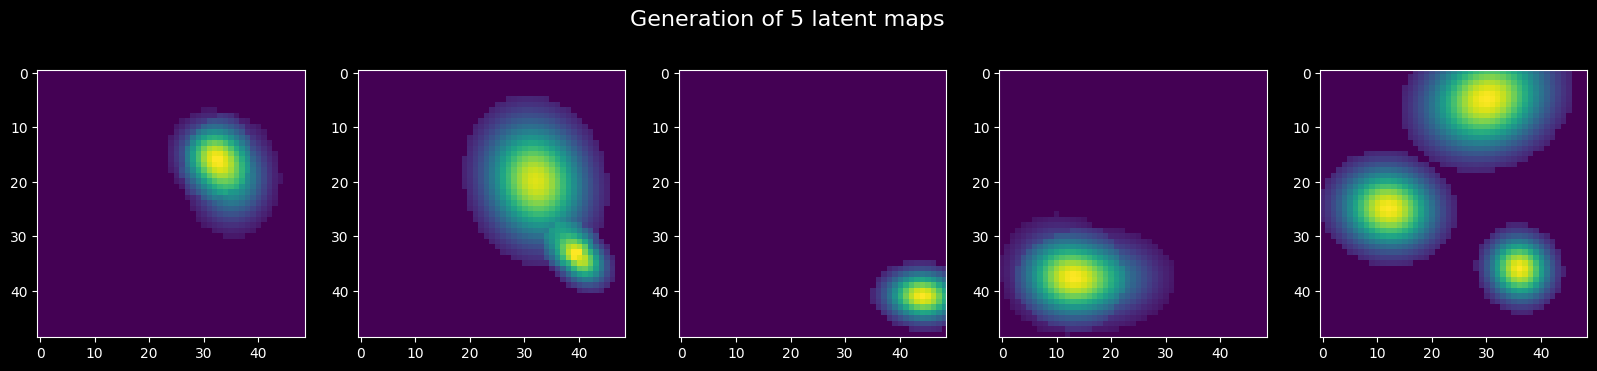

In [34]:
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Generation of 5 latent maps',fontsize=16)
for i in range(k):
    ax[i].imshow(latent_global_maps[i, :,:])
fig.show()

In [35]:
np.save('latent_global_maps', latent_global_maps)

<h3><u>b- Subject level latent spatial map</u><h3>

<span style="font-size: 17px;">  In addition, we generate subject-speciﬁc latent spatial maps by adding an isotropic, Gaussian-distributed, jitter on the blobs position and width.</span>


In [36]:
def get_subject_blobs(all_blobs: List[List[Blob]], jitter: float = 0, smoothness: float = 0) -> List[List[Blob]]:
    """ 
    Modifies and returns a list of blob lists, representing subject-specific blobs
    based on global blob characteristics, applying jitter and smoothness adjustments.
    
    Args:
    - all_blobs: A list of lists containing Blob objects.
    - jitter: The standard deviation of the normal distribution for center jitter.
    - smoothness: The standard deviation of the normal distribution for blob radius adjustment.
    
    Returns:
    - A list of lists containing adjusted Blob objects for a specific subject.
    """
    all_subject_blobs = []

    for blob_list in all_blobs:  # Iterates over each list of blobs corresponding to a latent map
        subject_blob_list = []

        for blob in blob_list:  # Iterates over individual blobs within a latent map
            subject_blob = blob.get_copy()  # Create a copy to avoid modifying the original blob

            # Apply noise to the blob's radius for smoothness effect
            noise_on_width = np.random.normal(loc=0, scale=smoothness)
            subject_blob.radius = max(subject_blob.radius + noise_on_width, 0)  # Ensure non-negative radius

            # Apply jitter to the blob's center (we take it integer for simplicity reasons)
            center_shift = np.random.normal(loc=0, scale=jitter, size=2).astype(int)
            
            # Ensure the blob's center remains within the grid boundaries
            subject_blob.center = np.clip(subject_blob.center + center_shift, 0, subject_blob.grid_length)

            subject_blob_list.append(subject_blob)

        all_subject_blobs.append(subject_blob_list)

    return all_subject_blobs

def get_latent_subject_maps_from_blobs(subject_blobs: List[List[Blob]], grid_length: int = 50) -> np.ndarray:
    """
    Generates latent subject maps from the list of the subject's blobs.
    
    """
    k = len(subject_blobs)
    latent_subject_maps = []
    for numMap in range(k):
        latent_subject_maps.append(generate_global_map(grid_length=grid_length, blobs=subject_blobs[numMap]))
    latent_subject_maps = np.array(latent_subject_maps)
    
    return latent_subject_maps


In [37]:
def create_subjects_latent_maps(all_blobs:List[List[Blob]], nbSubjects: int, jitter:int = 3, smoothness: int= 2, grid_length:int = 50):
    """This function takes a global set of blobs and generates individual latent maps for a given number of subjects.
    Each subject's maps are generated by applying jitter and smoothness to the blobs, which simulates individual variability.
    
    Args:
    - all_blobs: A list of lists containing Blob objects for each latent map.
    - nbSubjects: Number of subjects.
    - jitter: The standard deviation of the Gaussian noise added to the position of each blob to simulate jitter (default is 3).
    - smoothness: The standard deviation of the Gaussian noise added to the size of each blob to simulate smoothness (default is 2).
    
    """
    maps_from_subjects = []
    for num_subject in range(nbSubjects):
        subject_blobs = get_subject_blobs(all_blobs, jitter, smoothness)
        latent_subject_maps = get_latent_subject_maps_from_blobs(subject_blobs, grid_length=grid_length)
        maps_from_subjects.append(latent_subject_maps)
    return maps_from_subjects



In [38]:
# returns the list containing latent maps array (size (5,50,50)) for each subject
nbSubjects = 4
jitter = 3
smoothness= 2
maps_per_subject = create_subjects_latent_maps(all_blobs, nbSubjects = nbSubjects, jitter = jitter, smoothness= smoothness, grid_length=grid_length)

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_15699/502577363.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


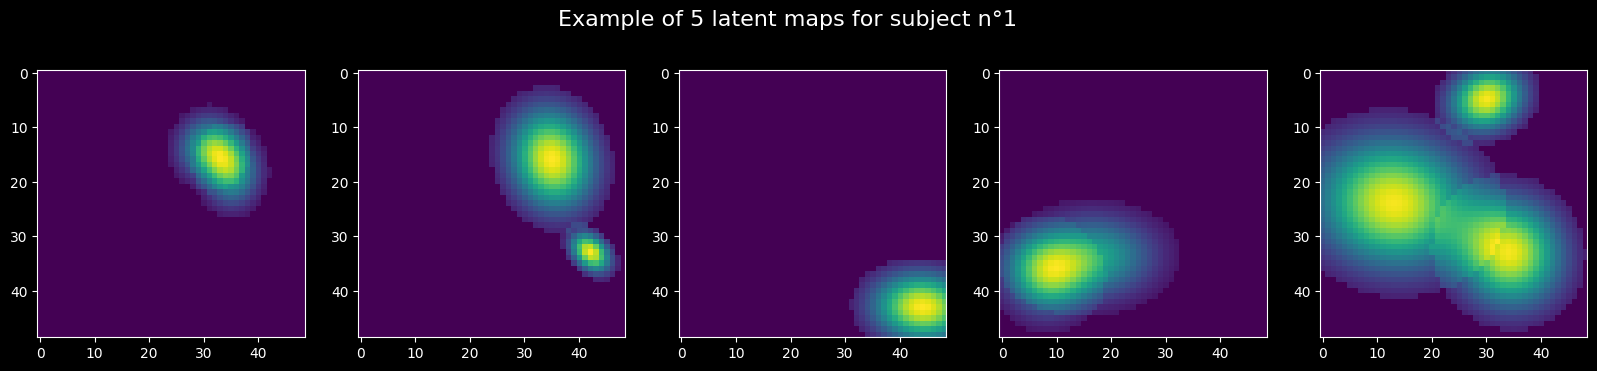

In [39]:
# Plotting the 5 latents maps generated 
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Example of 5 latent maps for subject n°1',fontsize=16)
for i in range(k):
    ax[i].imshow(maps_per_subject[0][i, :,:])
fig.show()


<h3><u>c- Generation of synthetic fmri data </u><h3>

<span style="font-size: 17px;">  From these maps, we generate observations by mixing them with random time series and adding random spatially-correlated Gaussian noise.</span>

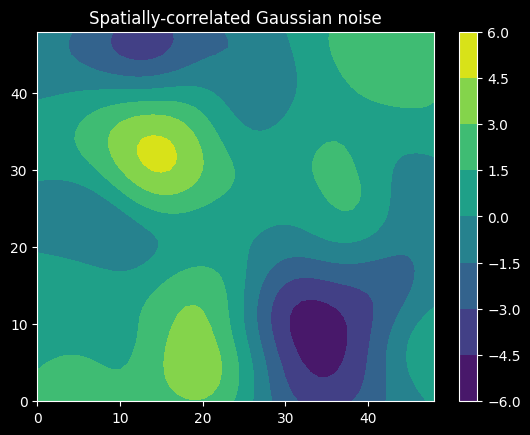

In [40]:
# Random spatially-correlated Gaussian noise representation
noise = get_random_spatially_correlated_noise(grid_length=grid_length, correlation_scale=0.5, sigma_final=2)
plt.contourf(np.arange(grid_length), np.arange(grid_length), noise)
plt.title('Spatially-correlated Gaussian noise')
plt.colorbar()

In [41]:
def generate_synthetic_fmri_data(n, maps_per_subjects:List[np.ndarray], sigma_space = 0.5, correlation_scale=0.3, sigma_ts=4):
    """Generates synthetic fMRI data for a group of subjects.

    This function simulates fMRI data by creating spatially correlated noise and combining it
    with subject-specific latent maps, which represent underlying brain activation patterns. 

    Args:
    - n (int): Number of time points
    - maps_per_subjects (List[np.ndarray]): A list containing arrays (k, grid_length, grid_length) for each subject .
    - sigma (float, optional): The standard deviation of the Gaussian noise added to each observation. Default is 0.5.
    - correlation_scale (float, optional): The scale of correlation for the spatially correlated noise. Default is 0.5.

    Returns:
    - np.ndarray: A 4D numpy array of shape (nbSubjects, n, grid_length, grid_length) containing the generated synthetic fMRI data.
    """
    
    nbSubjects = len(maps_per_subjects)
    k, grid_length, _ = maps_per_subject[0].shape
    
    data = np.zeros((nbSubjects, n, grid_length**2))

    for subject_idx in range(nbSubjects):
        subject_latent_maps = maps_per_subject[subject_idx] #of shape (k, grid_length, grid_length)
        
        subject_latent_vector = subject_latent_maps.reshape(k, grid_length**2) #careful: V_S.T in the article
        U_s = np.random.normal(loc=0, scale=sigma_ts, size=(n, k))

        spatial_noise = get_random_spatially_correlated_noise(grid_length=grid_length, sigma= sigma_space, correlation_scale= correlation_scale ).reshape(grid_length**2)
        observations = U_s @ subject_latent_vector + spatial_noise
        data[subject_idx] = observations

    return data.reshape(nbSubjects, n, grid_length, grid_length)

2.0

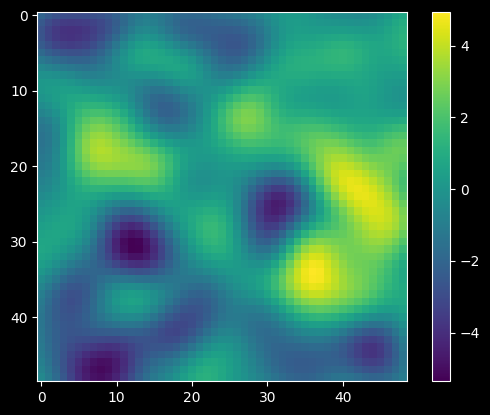

In [42]:
spatial_noise = get_random_spatially_correlated_noise(grid_length=grid_length, sigma= 3, correlation_scale= 0.2, sigma_final=2)
plt.imshow(spatial_noise)
plt.colorbar()

spatial_noise.std()

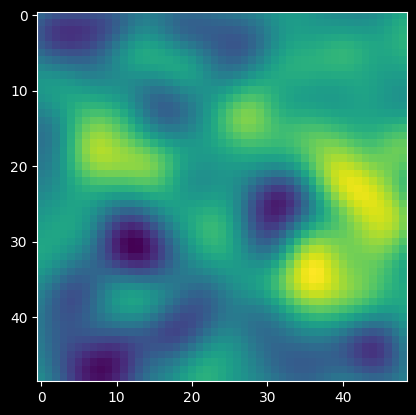

In [43]:
spatial_noise = spatial_noise.reshape(grid_length**2)
plt.imshow(spatial_noise.reshape(grid_length, grid_length))

In [44]:
# Parameters
time_points = 149

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(n = time_points, maps_per_subjects = maps_per_subject)
synthetic_data.shape

(4, 149, 49, 49)

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_15699/120280513.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


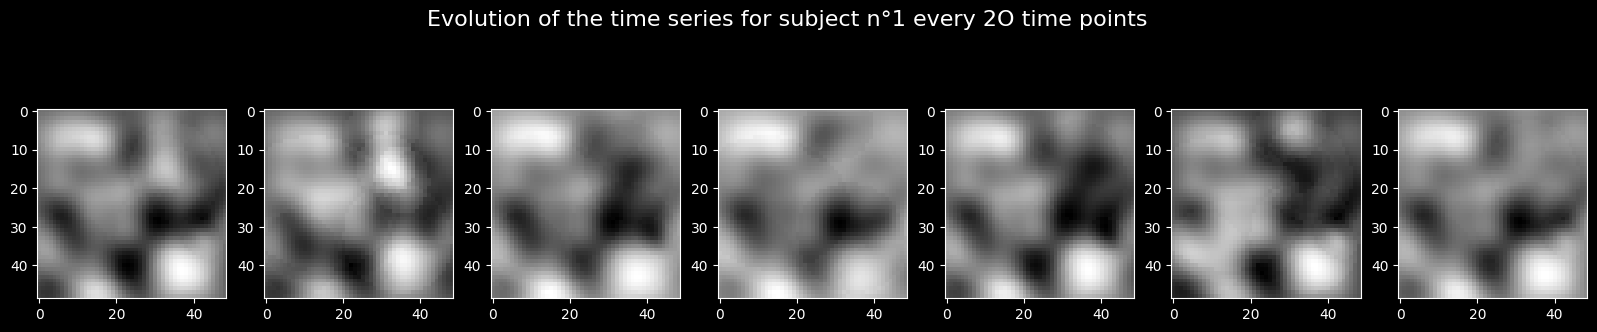

In [45]:
# Plotting the 5 latents maps generated 
fig, ax = plt.subplots(1, 7, figsize=(20, 4))
fig.suptitle('Evolution of the time series for subject n°1 every 2O time points',fontsize=16)
for i in range(7):
    ax[i].imshow(synthetic_data[0, 20*i, :, : ], cmap='gray')
fig.show()


In [46]:
data_fmri_path = "synthetic_data_prime"
np.save(data_fmri_path , synthetic_data)


<h2><u>2- Model </u><h2>



We consider a dataset of brain signal time series of length $n$ for $S$ subjects, measured on $p$ voxels: $\{Y_s \in \mathbb{R}^{n \times p}, s = 1 \ldots S\}$. We stipulate that the corresponding 3D images are the observation of $k$ spatial latent factors $V_s \in \mathbb{R}^{p \times k}$, that characterize functional processes or structured measurement artifacts, and associated time series $U_s \in \mathbb{R}^{n \times k}$: $Y_s \approx U_sV_s^\top$. 


In the case of a multi-subject dataset, we give a hierarchical probabilistic model for dictionary learning. 

\begin{equation}
\forall s \in \{1 \ldots S\}, Y_s = U_sV_s^\top + E_s, E_s \sim \mathcal{N}(0,\sigma I), U_s \sim \mathcal{N}(0,\Sigma_U)
\end{equation}

In addition, the subject-specific maps $V_s$ are generated from population-level latent factors, the spatial patterns written as brain maps $V$:

\begin{equation}
\forall s \in \{1 \ldots S\}, V_s = V + F_s, F_s \sim \mathcal{N}(0,\zeta I)
\end{equation}

The optimal dictionary elements and loading factors are obtained by minimizing the energy function:

\begin{equation}
(U_s, V_s)_{s \in \{1 \ldots S\}}, V = \arg\min E(U_s, V_s, V), \text{ s.t. } \|u_{sl}\|_2 \leq 1
\end{equation}

where $E(U_s,V_s,V)$ is given by:

\begin{equation}
E(U_s,V_s,V) = \sum_{s=1}^S \frac{1}{2} \left\|Y_s - U_sV_s^\top \right\|_{\text{Fro}}^2 + \mu \left\|V_s - V \right\|_{\text{Fro}}^2 + \lambda \Omega(V),
\end{equation}

and the regularization term $\Omega_{SL}(v)$ is defined as:

\begin{equation}
\Omega_{SL}(v) = \|v\|_1 + \frac{1}{2}v^\top L v
\end{equation}



In [47]:
def get_init_V(data_fmri: np.ndarray, n_components: int) -> np.ndarray:
    S, n, p1, _ = data_fmri.shape
    X = data_fmri.reshape(S*n, p1, p1)
    X = X.reshape(S*n, p1 * p1) #in 2 steps in case it causes problems
    ica_estimator = FastICA(
                    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5)
    ica_estimator.fit(X)

    components = ica_estimator.components_[:n_components]
    
    return components

def plot_latent_maps(V: np.ndarray, n_components) -> None:
    fig, ax = plt.subplots(1, n_components, figsize=(20, 4))
    fig.suptitle(f'Initialization of the {n_components} latent maps', fontsize=16)
    for i in range(n_components):
        ax[i].imshow(V[i, :,:], cmap="inferno")
    fig.show()

def read_fmri(path: str) -> np.ndarray:
    data_fmri = np.load(path)
    S,n,_,_ = data_fmri.shape
    Ys = data_fmri.reshape(S, n, -1) # need to be of shape (S,n,p)
    return Ys


V = get_init_V(synthetic_data , n_components = k)
print(V.shape)
#plot_latent_maps(V, k)
#Ys = read_fmri(f'{data_fmri_path}.npy')
Ys = synthetic_data.reshape(4, 149, -1)
Ys.shape


(5, 2401)


(4, 149, 2401)

In [48]:
class MDSLModel:
    def __init__(self, grid_length: int = 50, k: int = 5, mu: float = 0.1, lambd: float= 0.1) -> None:
        self.grid_length = grid_length
        self.L = MDSLModel.create_2d_laplacian(grid_length)
        self.k = k 
        self.mu = mu
        self.lambd = lambd

    @staticmethod
    def create_2d_laplacian(grid_length: int):
        # Création de la matrice laplacienne pour une grille 1D
        e = np.ones(grid_length)
        laplacian_1d = np.diag(2 * np.ones(grid_length)) - np.diag(np.ones(grid_length - 1), k=1) - np.diag(np.ones(grid_length - 1), k=-1)
        
        # Création de la matrice laplacienne pour une grille 2D
        I = np.eye(grid_length)
        laplace_2d = np.kron(I, laplacian_1d) + np.kron(laplacian_1d, I)
        return laplace_2d
    
    def regularizer(self, V: np.ndarray):
        _, k = V.shape
        norm1_v = np.sum(np.abs(V))
        quadratic_term = 0
        for i in range(k):
            quadratic_term += 0.5 * (V[:, i].T @ self.L @ V[:, i])
        return norm1_v + quadratic_term
    
    def omega(self, v_grid):
        """
        returns omega(v) where v is a np array of size p1*p2
        """
        norm1_v = np.sum(np.abs(v_grid))

        lv = laplacian(v_grid)
        vT_lv = np.sum(v_grid * lv)
        
        return norm1_v + 1/2 * vT_lv
    
    def omega_v_vector(self, V):
        """ 
        V is of shape (grid_length*grid_length, k) with k number of components
        """
        p_squared, k = V.shape
        p = int(np.sqrt(p_squared))
        omega_summed = 0
        for num_component in range(k):
            omega_summed += omega(V[:, num_component].reshape(p, p))
        
        return omega_summed

    def compute_energy(self, Ys, Us, Vs, V):
        S = len(Us)  # Number of subjects
        energy = 0
        for s in range(S):
            term1 = np.linalg.norm(Ys[s] - Us[s] @ Vs[s].T, 'fro')**2
            term2 = self.mu * np.linalg.norm(Vs[s] - V, 'fro')**2
            energy += 0.5 * (term1 + term2)
        #regularization_term = self.regularizer(V)
        regularization_term = self.omega_v_vector(V)
        energy += self.lambd * regularization_term
        return energy

    def update_vs(self, V, us, ys):
        id_matrix = np.identity(us.shape[1])
        vs = V + (ys - us @ V.T).T @ us @ np.linalg.inv(us.T @ us + self.mu * id_matrix)
        return vs

    def update_us(self, ys, vs, us):
        for l in range(self.k):
            u_l, v_l = us[:, l], vs[:, l]
            u_l_new = u_l + np.linalg.norm(v_l, 2)**-2 * (ys - us @ vs.T) @ v_l
            us[:, l] = u_l_new / max(np.linalg.norm(u_l_new, 2), 1)
        return us
    
    @staticmethod
    def soft_thresholding(x, lambd):
        """Element-wise soft-thresholding operator."""
        return np.sign(x) * np.maximum(np.abs(x) - lambd, 0)
        
    def smooth_lasso_prox(self, v: np.ndarray, gamma: float, kappa: float, m: int = 100):
        v_star = copy.deepcopy(v)
        z = copy.deepcopy(v_star)
        tau = 1
        
        for l in range(m):
            v0 = v_star.copy()
            # Soft-thresholding operation
            v_star = MDSLModel.soft_thresholding(z - kappa * (z - v + gamma * self.L @ z), kappa * gamma)
            tau_0 = tau
            tau = (1 + np.sqrt(1 + 4 * tau ** 2)) / 2
            z = v_star + ((tau_0 - 1) / tau) * (v_star - v0)
        return v_star

    def __call__(self,
                 Ys: np.ndarray,
                 V: np.ndarray,
                 gamma: np.ndarray,
                 kappa: np.ndarray,
                 max_iter=1000,
                 tolerance: float =1e-4):
        """_summary_

        Args:
            Ys (np.ndarray): _description_
            V (np.ndarray): _description_
            gamma (np.ndarray): _description_
            kappa (np.ndarray): _description_
            max_iter (int, optional): _description_. Defaults to 1000.
            tolerance (float, optional): _description_. Defaults to 1e-4.

        Returns:
            _type_: _description_
        """
        n, p = Ys.shape[1:]  # n number of time points, p number of voxels 
        S = len(Ys)          # S number of subjects
        Vs = [np.random.rand(p, self.k) for _ in range(S)]  # Subject specific spatial maps
        Us = [np.random.rand(n, self.k) for _ in range(S)]  # Time series
        E_old = self.compute_energy(Ys, Us, Vs, V) * 2 # *2 ?
        E_new = self.compute_energy(Ys, Us, Vs, V)

        i = 0  # Iteration counter
        while np.abs(E_new - E_old) > tolerance * E_old and i < max_iter:
            E_old = E_new
            # Update each U^s
            for s in range(S):
                Us[s] = self.update_us(Ys[s], Vs[s], Us[s])
                Vs[s] = self.update_vs(V, Us[s], Ys[s])

            Vs_mean = np.mean(Vs, axis=0)
            # Apply the proximal operator to the mean of every subject spatial maps
            for j in range(self.k):
                V[:, j] = self.smooth_lasso_prox(v = Vs_mean[:, j], gamma = gamma, kappa = kappa)
            
            # Compute the energy
            E_new = self.compute_energy(Ys, Us, Vs, V)
            i += 1
            print(f'Iteration : {i} Energy: {E_new}')
        
        return V, Vs, Us


In [61]:
Ys.shape

(4, 149, 2401)

In [63]:
model = MDSLModel(grid_length = grid_length)

V, Vs, Us = model(Ys= Ys , V=V.reshape(grid_length**2,k), gamma= 0.1 , kappa=0.1, max_iter=30,  tolerance=1e-4)

Iteration : 1 Energy: 3497936.613397338
Iteration : 2 Energy: 1682469.0121135865
Iteration : 3 Energy: 966250.1609446455
Iteration : 4 Energy: 716865.8623326988
Iteration : 5 Energy: 606037.8015244203
Iteration : 6 Energy: 549637.7684168016
Iteration : 7 Energy: 512873.45363460673
Iteration : 8 Energy: 485736.7484346454
Iteration : 9 Energy: 466017.60168016824
Iteration : 10 Energy: 451276.26342801435
Iteration : 11 Energy: 439245.6367202578
Iteration : 12 Energy: 429276.48261660925
Iteration : 13 Energy: 420914.13980467606
Iteration : 14 Energy: 413826.21964779135
Iteration : 15 Energy: 407763.30450872524
Iteration : 16 Energy: 402533.6246033114
Iteration : 17 Energy: 397988.51096220134
Iteration : 18 Energy: 394010.35339639813
Iteration : 19 Energy: 390505.18975817994
Iteration : 20 Energy: 387397.56921273866
Iteration : 21 Energy: 384626.1373662593
Iteration : 22 Energy: 382140.98244080035
Iteration : 23 Energy: 379900.6037397244
Iteration : 24 Energy: 377870.44900986314
Iteration :

Il faut faire attention pour le reshape pour visualiser bien, c'était bien transposer qu'il fallait faire

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_15699/1804863035.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


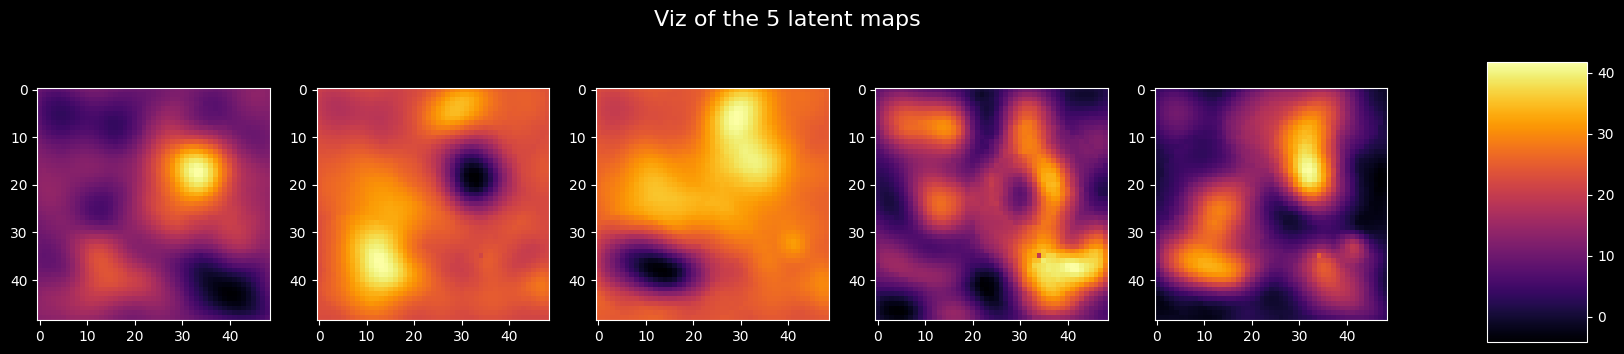

In [64]:
fig, ax = plt.subplots(1, k, figsize=(20, 4))
fig.suptitle(f'Viz of the {k} latent maps', fontsize=16)
for i in range(k):
    im = ax[i].imshow(V.transpose((1, 0))[i].reshape(49,49), cmap="inferno")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

Les résultats sont pas foufous mais au moins maintenant ils existent haha